<a href="https://colab.research.google.com/github/DT6A/JBRamachandran/blob/master/JBRamachandran2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading PDB files

In [1]:
!wget -q https://files.rcsb.org/download/1DLE.pdb
!wget -q https://files.rcsb.org/download/1G8P.pdb
!wget -q https://files.rcsb.org/download/1E1E.pdb

Imports and setup

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from math import pi

In [3]:
plt.rcParams["figure.figsize"] = (10,10)

Functionality

In [22]:
'''
  Draw Ramachandran map
  Arguments:
    phis -- array of phis angles
    psis -- array of psis angles
    show -- show plot at the end of function
    title -- plot title
    label -- dots label
  Returns: None
'''
def draw_ramachandran(phis, psis, show=True, title=None, label=None):
  plt.scatter(phis, psis, s=5, label=label)
  plt.title(title)
  plt.xlabel('$\phi$', fontsize=20)
  plt.ylabel('$\psi$', fontsize=20)
  plt.xlim(-180, 180)
  plt.ylim(-180, 180)
  plt.axhline(0, color='black', linewidth=1)
  plt.axvline(0, color='black', linewidth=1)
  plt.xticks(np.arange(-180, 181, 30))
  plt.yticks(np.arange(-180, 181, 30))
  plt.grid(True)
  plt.annotate(r'$\alpha_r$', (-57, -47), c='black', fontsize=30)
  plt.annotate(r'$\beta$', (-119, 113), c='black', fontsize=30)
  plt.annotate(r'$\alpha_l$', (57, 47), c='black', fontsize=30)
  if show:
    plt.show()

'''
  Extract N-CA-C backbone from file
  Arguments:
    file_name -- name of file to extract from
  Returns: array of backbone coordinates
'''
def extract_backbone(file_name):
  with open(file_name, 'r') as inf:
    lines = [l for l in inf]
    i = 0

    while i < len(lines):
      line = lines[i].split()
      i += 1
      if 'CHAIN:' in line:
        chains = list(map(lambda x: x[0], line[3:]))
        break

    chains_backbones = {}
    for c in chains:
      chains_backbones[c] = []
    
    while i < len(lines):
      line = lines[i].split()
      i += 1
      if line[0] == 'ATOM':
        atom = line[2]
        if atom == 'N' or atom == 'CA' or atom == 'C':
          chains_backbones[line[4]].append(list(map(float, line[6:9])))
    for c in chains:
      chains_backbones[c] = np.array(chains_backbones[c])
    return chains_backbones

'''
  Evaluate dihedral angles
  Arguments:
    coords -- backbone coordinates
    offset -- which atom to start with
  Returns: array of dihedral angles
'''
def eval_dihedrals(coords, offset):
  p3 = coords[3 + offset::3]
  lp3 = len(p3) 
  p0 = coords[0 + offset::3][:lp3]
  p1 = coords[1 + offset::3][:lp3]
  p2 = coords[2 + offset::3][:lp3]
  

  b0 = -1.0 * (p1 - p0)
  b1 = p2 - p1
  b2 = p3 - p2

  b1 = np.array([v1 / np.linalg.norm(v1) for v1 in b1])

  v = b0 - np.repeat(list([np.dot(v1, v2) for v1, v2 in zip(b0, b1)]), 3).reshape(-1, 3) * b1
  w = b2 - np.repeat(list([np.dot(v1, v2) for v1, v2 in zip(b2, b1)]), 3).reshape(-1, 3) * b1

  x = np.array(list([np.dot(v1, v2) for v1, v2 in zip(v, w)]))
  y = np.array(list([np.dot(v1, v2) for v1, v2 in zip(np.cross(b1, v), w)]))
  return list(np.degrees(np.arctan2(y, x)))

'''
  Evaluate torsion angles for the given protein
  Arguments:
    file_name -- PDB file name to process
  Returns: pair of arrays of dihedral angles
'''
def process_file(file_name):
  chains = extract_backbone(file_name)
  phis = []
  psis = []
  for c in chains:
    ph = eval_dihedrals(chains[c], 2)
    ps = eval_dihedrals(chains[c], 0)[1:]
    if len(ps) < len(ph):
      ph = ph[:-1]
    phis += ph
    psis += ps
  #print("END")
  return (phis, psis)

Drawing maps

In [23]:
files = ['1DLE.pdb', '1G8P.pdb', '1E1E.pdb']

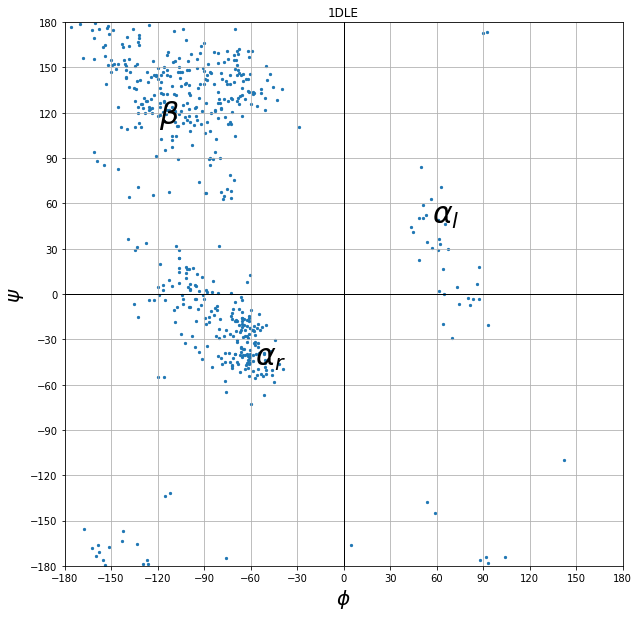

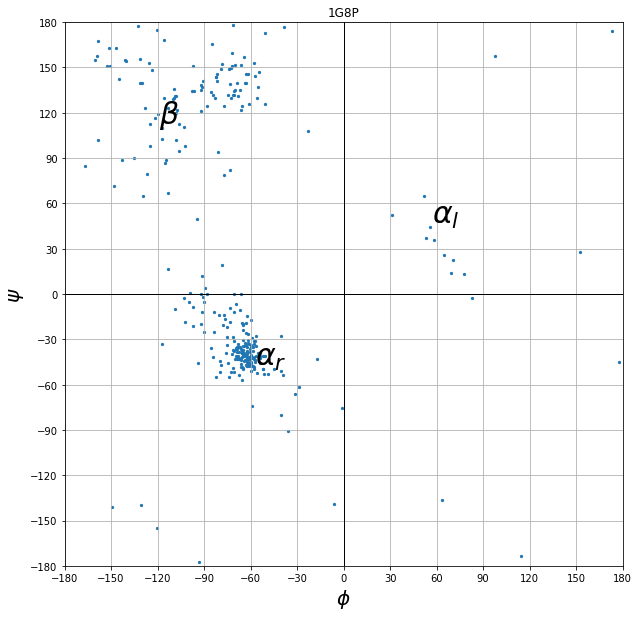

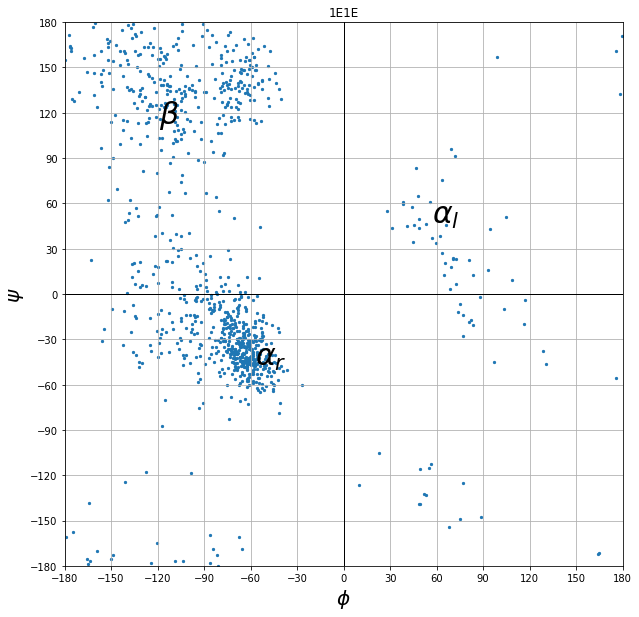

In [24]:
for file in files:
  phis, psis = process_file(file)
  draw_ramachandran(phis, psis, title=file[:4])

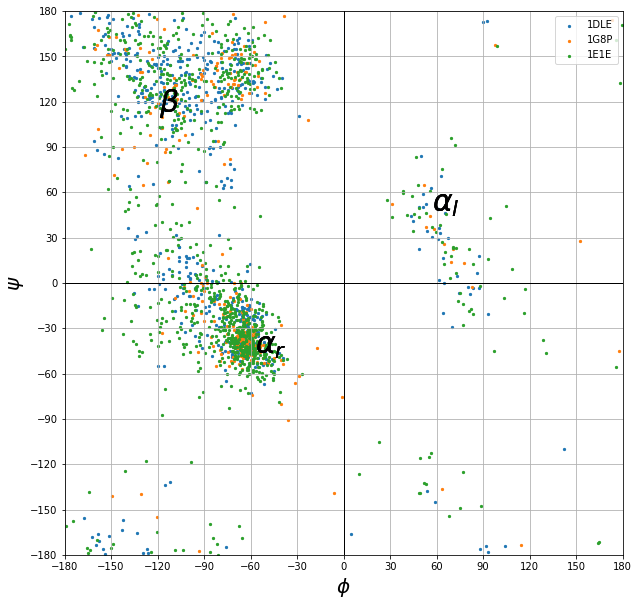

In [25]:
for file in files:
  phis, psis = process_file(file)
  draw_ramachandran(phis, psis, show=False, label=file[:4])
plt.legend()
plt.show()